In [1]:
pip install numpy==1.23.0
pip install git+https://github.com/yyoshiaki/NMFprojection.git
pip install decoupler

SyntaxError: invalid syntax (2265755326.py, line 1)

In [35]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata as ad
import re
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor
import copy
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings
from matplotlib.lines import Line2D
from matplotlib import cm
import math
from pathlib import Path
from NMFproj import *
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Suppress all warnings
warnings.filterwarnings('ignore')
import math
import decoupler as dc

### START

In [13]:
%%time
#load file for day 0,7,90 for year 1 and 2
load_data=sc.read_h5ad("/home/jupyter/formal_BRIanalysis/DEG_Mehul/for_3times_2yr.h5ad")

CPU times: user 58.3 s, sys: 2min 51s, total: 3min 50s
Wall time: 19min 47s


In [14]:
load_data

AnnData object with n_obs × n_vars = 8277628 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'

In [98]:
%%time
# Step 2: Create a boolean mask for filtering
mask = load_data.obs['pbmc_sample_id'].apply(lambda x: x in unique_ids)

CPU times: user 42.9 ms, sys: 23.3 ms, total: 66.2 ms
Wall time: 65.2 ms


In [ ]:
%%time
# Filter load_data to keep only those rows where pbmc_sample_id is in unique_ids
load_data_filtered = load_data[load_data.obs['pbmc_sample_id'].isin(unique_ids)].copy()

In [ ]:
load_data_filtered

## Subset on memory CD4 and do analysis

In [62]:
# subset_pops = ['CM CD4 T cell',
#  'GZMB- CD27+ EM CD4 T cell',
#  'KLRB1+ memory CD4 Treg',
#  'KLRF1- GZMB+ CD27- memory CD4 T cell',
#  'Naive CD4 Treg',
#  'GZMB- CD27- EM CD4 T cell',
#  'Memory CD4 Treg',
#  'ISG+ memory CD4 T cell',
#  'GZMK+ memory CD4 Treg',
# 'Proliferating T cell']

subset_pops = ['CM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'ISG+ memory CD4 T cell']

# subset on memory cd4
CD4mem = load_data[load_data.obs['AIFI_L3'].isin(subset_pops)]

# Define the visit names and corresponding file names
visit_names = {
    'Flu Year 1 Day 0': 'CD4_mem_yr1d0',
    'Flu Year 1 Day 7': 'CD4_mem_yr1d7',
    'Flu Year 2 Day 0': 'CD4_mem_yr2d0',
    'Flu Year 2 Day 7': 'CD4_mem_yr2d7'
}

for visit_name, file_name in visit_names.items():
    # Subset data for each visit
    subset_data = CD4mem[CD4mem.obs['sample.visitName'].isin([visit_name])]

    # copy of the data in the raw attribute and normalize/log
    subset_data.raw = subset_data.copy()
    sc.pp.normalize_total(subset_data, target_sum=1e4, inplace=True)
    sc.pp.log1p(subset_data)

    # Save
    output_path = f'/home/jupyter/formal_BRIanalysis/CD4 mem analysis/{file_name}.h5ad'
    subset_data.write(output_path)
    print(f"Processed data saved to: {output_path}")

Processed data saved to: /home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr1d0.h5ad
Processed data saved to: /home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr1d7.h5ad
Processed data saved to: /home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr2d0.h5ad
Processed data saved to: /home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr2d7.h5ad


### Load files and do NMF projection

In [54]:
%%time
CD4_mem_yr1d0=sc.read_h5ad("/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr1d7.h5ad")

CPU times: user 1.86 s, sys: 3.78 s, total: 5.63 s
Wall time: 5.63 s


In [55]:
CD4_mem_yr1d0

AnnData object with n_obs × n_vars = 296949 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    uns: 'log1p'

In [56]:
#randomly take 100,000 cells
random_subset = np.random.choice(CD4_mem_yr1d0.obs.index, size=100000, replace=False)
subsampled_adata = CD4_mem_yr1d0[random_subset, :]

In [57]:
# Path to the NMF weights CSV file
fixed_W_path = "/home/jupyter/formal_BRIanalysis/CD4 mem analysis/NMF.W.CD4T (1).csv"

# Read the fixed weights
fixed_W = pd.read_csv(fixed_W_path)
fixed_W = fixed_W.rename(columns={'Unnamed: 0': ''})
fixed_W.set_index(fixed_W.columns[0], inplace=True)

In [58]:
%%time
X = subsampled_adata.raw.to_adata().to_df().T

CPU times: user 2.95 s, sys: 7.54 s, total: 10.5 s
Wall time: 10.5 s


In [59]:
%%time
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(X, fixed_W, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)
#df_stats = calc_hvg_overlap(X_norm, fixed_W_trunc, min_mean=0.0125, max_mean=3, min_disp=0.1,
#                            n_top_genes=500)

CPU times: user 2min 8s, sys: 1min 34s, total: 3min 42s
Wall time: 34 s


In [60]:
# print('\n## Stats of overlap of HVGs')
# msg = 'Num. genes in fixed W: %s \n' % fixed_W.shape[0]
# msg += 'Num. Retained genes (Prop.): %s (%s)\n' % (fixed_W_trunc.shape[0], fixed_W_trunc.shape[0]/fixed_W.shape[0])
# msg += 'Prop. overlap of HVGs (POH) : {} in {} query HVGs'.format(
#     df_stats.loc[df_stats['highly_variable'], 'selected'].sum() / df_stats['highly_variable'].sum(), 
#     df_stats.highly_variable.sum())
# print(msg)

In [61]:
index_mapping = {
    'NMF_0': 'NMF0_Cytotoxic',
    'NMF_1': 'NMF1_Treg',
    'NMF_2': 'NMF2_Th17',
    'NMF_3': 'NMF3_Naive',
    'NMF_4': 'NMF4_Act',
    'NMF_5': 'NMF5_Th2',
    'NMF_6': 'NMF6_Tfh',
    'NMF_7': 'NMF7_IFN',
    'NMF_8': 'NMF8_Cent_Mem',
    'NMF_9': 'NMF9_Thymic_Emi',
    'NMF_10': 'NMF10_Tissue',
    'NMF_11': 'NMF11_Th1'
}

# Rename the index using the mapping
df_H.index = df_H.index.map(index_mapping)

#norm each cell weights
df_H_norm = (df_H.T / df_H.max(axis=1))

In [62]:
%%time
subsampled_adata.obs = pd.merge(subsampled_adata.obs, df_H_norm, left_index=True, right_index=True)

CPU times: user 797 ms, sys: 945 ms, total: 1.74 s
Wall time: 1.74 s


In [63]:
subsampled_adata.write('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/subsampled_adata.h5ad')

In [ ]:
# List of file names
file_names = [
    "CD4_all_yr1d0", "CD4_all_yr1d7", 
    "CD4_all_yr2d0", "CD4_all_yr2d7"
]

for file_name in file_names:
    file_path = f"/home/jupyter/formal_BRIanalysis/CD4 mem analysis/{file_name}.h5ad"
    adata = sc.read_h5ad(file_path)

    # Do NMF projections
    X = adata.raw.to_adata().to_df().T
    X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(X, fixed_W, return_truncated=True, normalized=True)
    df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)
    df_stats = calc_hvg_overlap(X_norm, fixed_W_trunc, min_mean=0.0125, max_mean=3, min_disp=0.1, n_top_genes=500)

    # Output some statistics as suggested by Pravina
    print('\n## Stats of overlap of HVGs')
    msg = 'Num. genes in fixed W: %s \n' % fixed_W.shape[0]
    msg += 'Num. Retained genes (Prop.): %s (%s)\n' % (fixed_W_trunc.shape[0], fixed_W_trunc.shape[0]/fixed_W.shape[0])
    msg += 'Prop. overlap of HVGs (POH) : {} in {} query HVGs'.format(
        df_stats.loc[df_stats['highly_variable'], 'selected'].sum() / df_stats['highly_variable'].sum(), 
        df_stats.highly_variable.sum())
    print(msg)

    # Index mapping
    index_mapping = {
        'NMF_0': 'NMF0_Cytotoxic', 'NMF_1': 'NMF1_Treg', 'NMF_2': 'NMF2_Th17',
        'NMF_3': 'NMF3_Naive', 'NMF_4': 'NMF4_Act', 'NMF_5': 'NMF5_Th2',
        'NMF_6': 'NMF6_Tfh', 'NMF_7': 'NMF7_IFN', 'NMF_8': 'NMF8_Cent_Mem',
        'NMF_9': 'NMF9_Thymic_Emi', 'NMF_10': 'NMF10_Tissue', 'NMF_11': 'NMF11_Th1'
    }

    # Rename the index using the mapping
    df_H.index = df_H.index.map(index_mapping)

    # Normalize each cell weights
    df_H_norm = (df_H.T / df_H.max(axis=1))

    # Merge with original AnnData
    adata.obs = pd.merge(adata.obs, df_H_norm, left_index=True, right_index=True)

    # Save the updated AnnData
    adata.write(file_path)
    print(f"Updated AnnData saved to {file_path}")

### Visualize NMF projection for each cell type in each cohort

In [64]:
# Load the metadata
meta_data = pd.read_csv('/home/jupyter/formal_BRIanalysis/DEG_Mehul/hise_meta_data_2024-03-7_fixed.csv')
meta_data = meta_data[meta_data['Covid_exlcusion'] == 'no']

# Define the conditions
conditions = [
    ("Flu Year 1 Day 0", 2020, "Phuket+Guangdong-Maonan+Hongkong+Washington"),
    ("Flu Year 1 Day 7", 2020, "Phuket+Guangdong-Maonan+Hongkong+Washington"),
    ("Flu Year 1 Day 90", 2020, "Phuket+Guangdong-Maonan+Hongkong+Washington"),
    ("Flu Year 2 Day 0", 2021, "Phuket+Victoria+Cambodia+Washington"),
    ("Flu Year 2 Day 7", 2021, "Phuket+Victoria+Cambodia+Washington"),
    ("Flu Year 2 Day 90", 2021, "Phuket+Victoria+Cambodia+Washington")
]

# Create an empty DataFrame to store the filtered data
filtered_data = pd.DataFrame()

# Filter the data based on the conditions
for visit_name, flu_year, strains_concat in conditions:
    subset = meta_data[(meta_data['sample.visitName'] == visit_name) & 
                       (meta_data['Flu_Year'] == flu_year) & 
                       (meta_data['Strains_concat'] == strains_concat)]
    filtered_data = pd.concat([filtered_data, subset])

In [65]:
# Get unique pbmc_sample_id values from filtered_data
unique_ids = filtered_data['pbmc_sample_id'].unique()

In [66]:
%%time
test = sc.read_h5ad('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/subsampled_adata.h5ad')
# nmf_features = [
#     'NMF0_Cytotoxic', 'NMF1_Treg', 'NMF2_Th17', 'NMF3_Naive', 'NMF4_Act',
#     'NMF5_Th2', 'NMF6_Tfh', 'NMF7_IFN', 'NMF8_Cent_Mem', 'NMF9_Thymic_Emi',
#     'NMF10_Tissue', 'NMF11_Th1'
# ]


#do the following to take out the samples that are not specific to flu strain
# Create a boolean mask for filtering
mask = test.obs['pbmc_sample_id'].apply(lambda x: x in unique_ids)

# Use the mask to filter load_data
test1 = test[mask].copy()

CPU times: user 1.4 s, sys: 1.86 s, total: 3.26 s
Wall time: 3.26 s


In [67]:
df = test1.obs.copy()

# Filter columns for NMF and necessary categorical data
nmf_cols = [col for col in df.columns if col.startswith('NMF')]
cat_cols = ['subject.subjectGuid', 'AIFI_L3']
df_filtered = df[nmf_cols + cat_cols]

# Group by 'subject.subjectGuid' and 'AIFI_L3', then calculate the mean of NMF columns
# For 'cohort.cohortGuid', take the first value
grouped = df_filtered.groupby(['subject.subjectGuid', 'AIFI_L3']).mean()
grouped['cohort.cohortGuid'] = df.groupby(['subject.subjectGuid', 'AIFI_L3'])['cohort.cohortGuid'].first()
grouped['pbmc_sample_id'] = df.groupby(['subject.subjectGuid', 'AIFI_L3'])['pbmc_sample_id'].first()

# Reset the index for plotting
grouped_reset = grouped.reset_index()

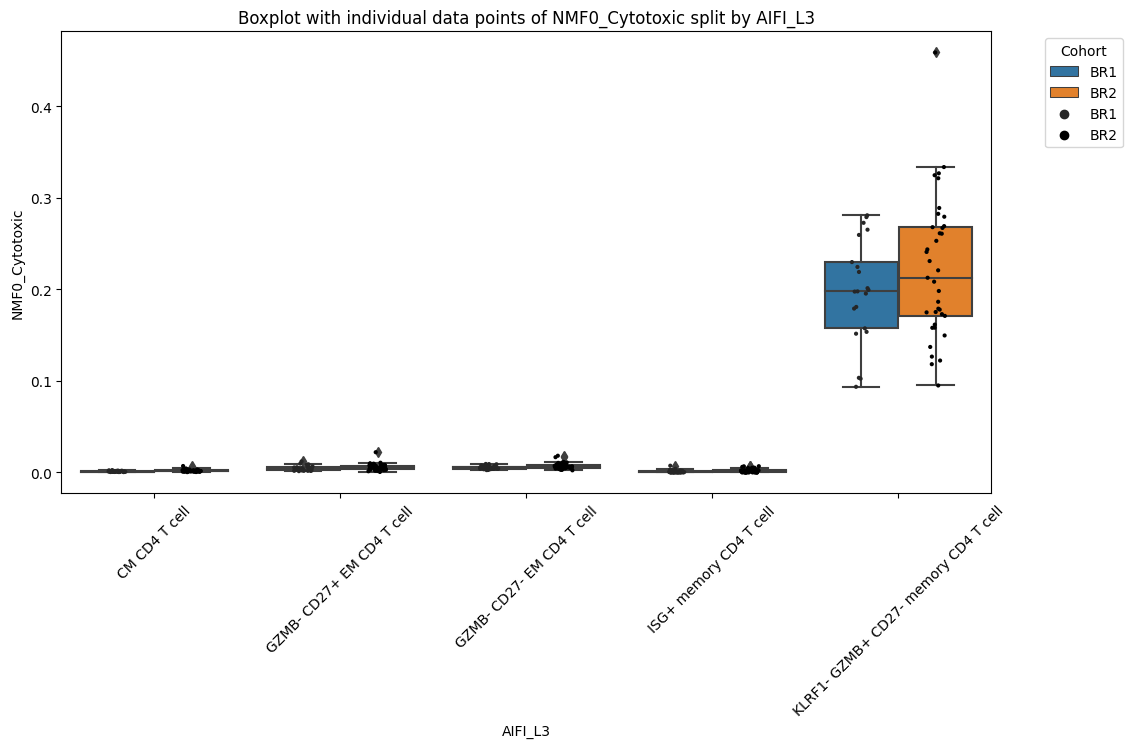

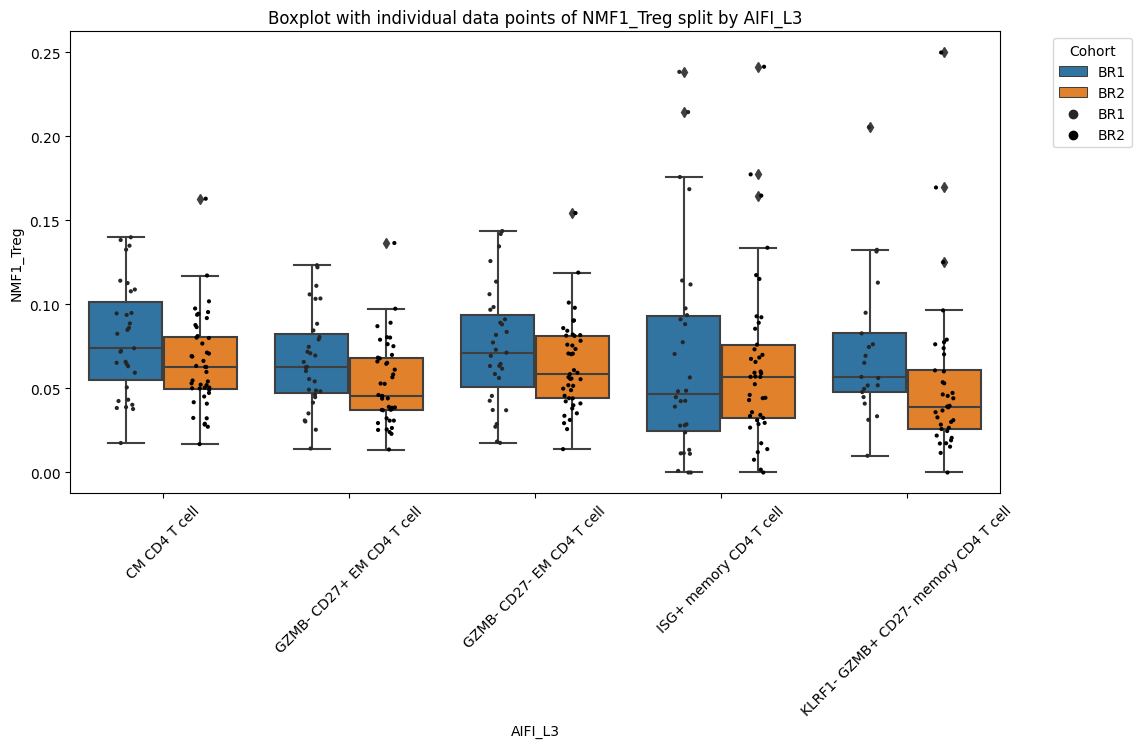

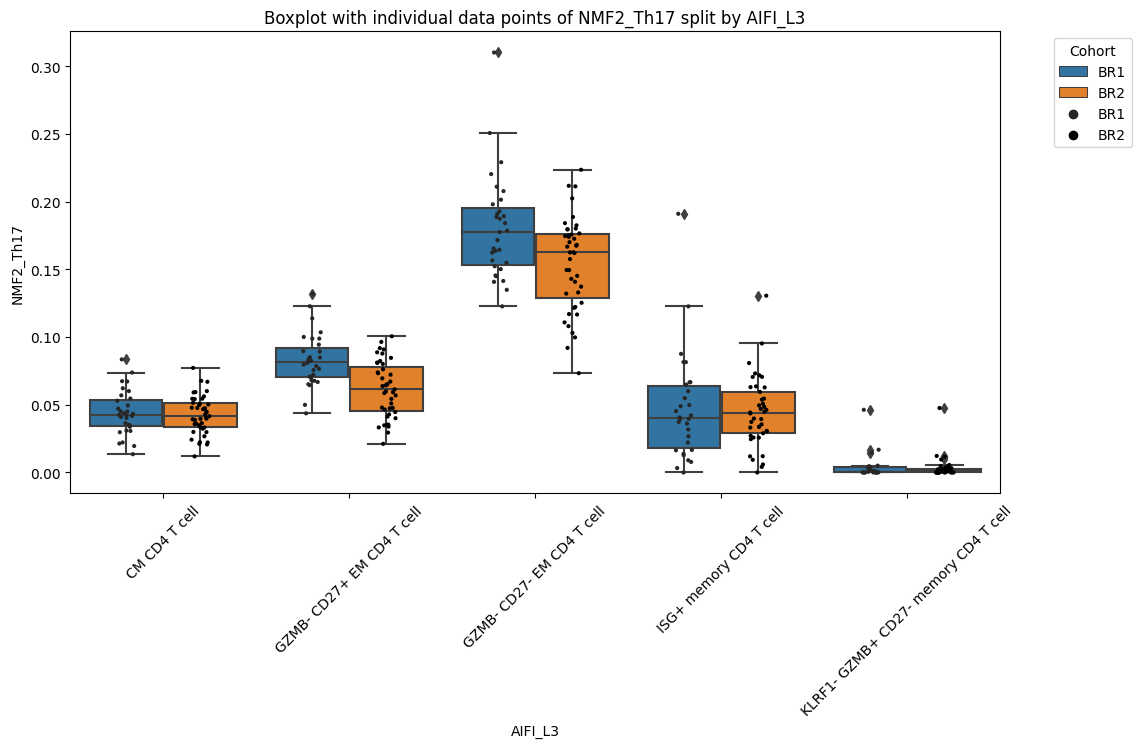

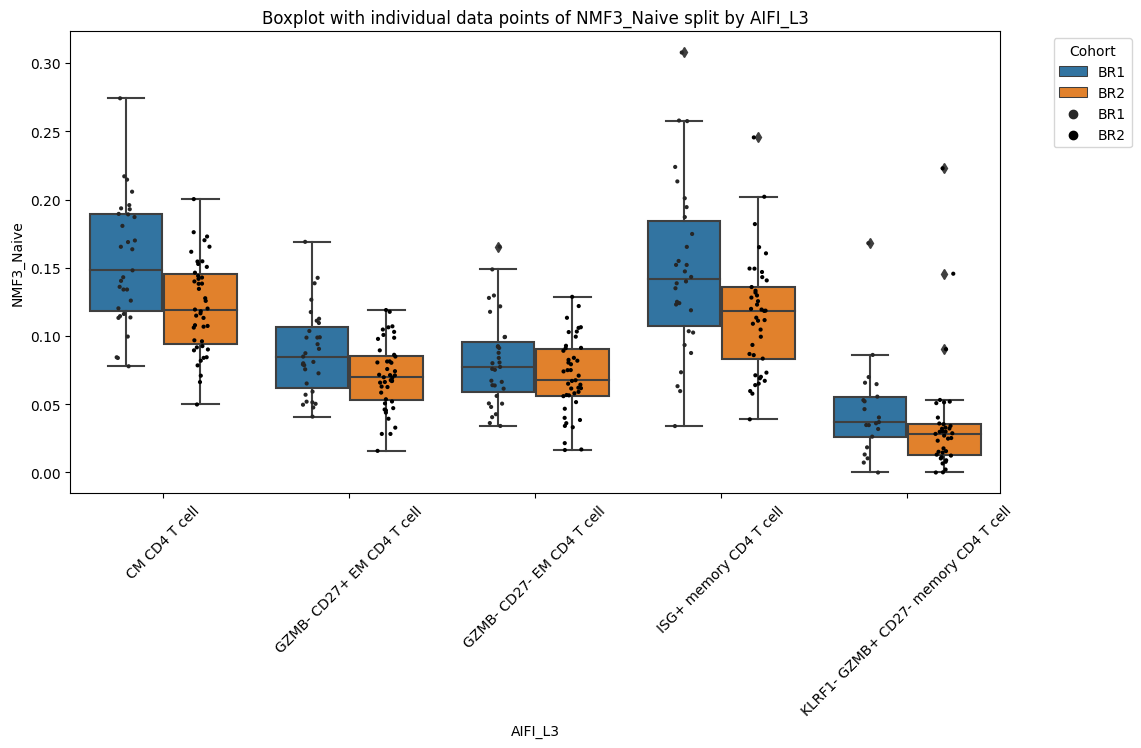

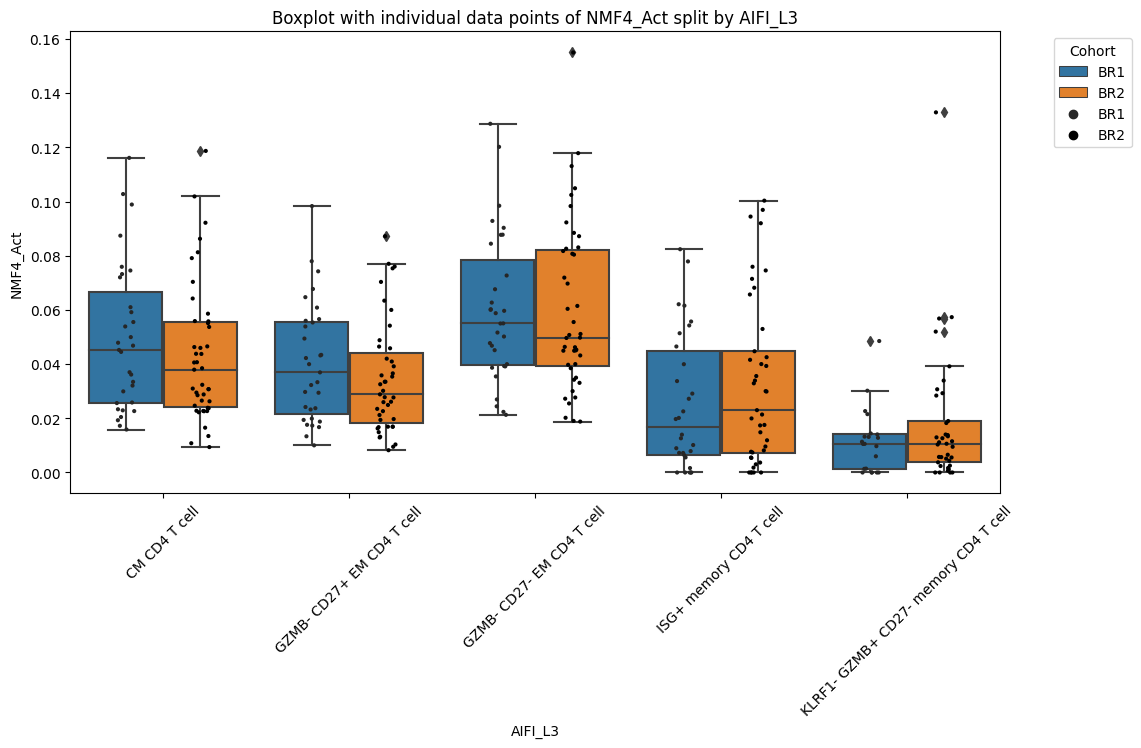

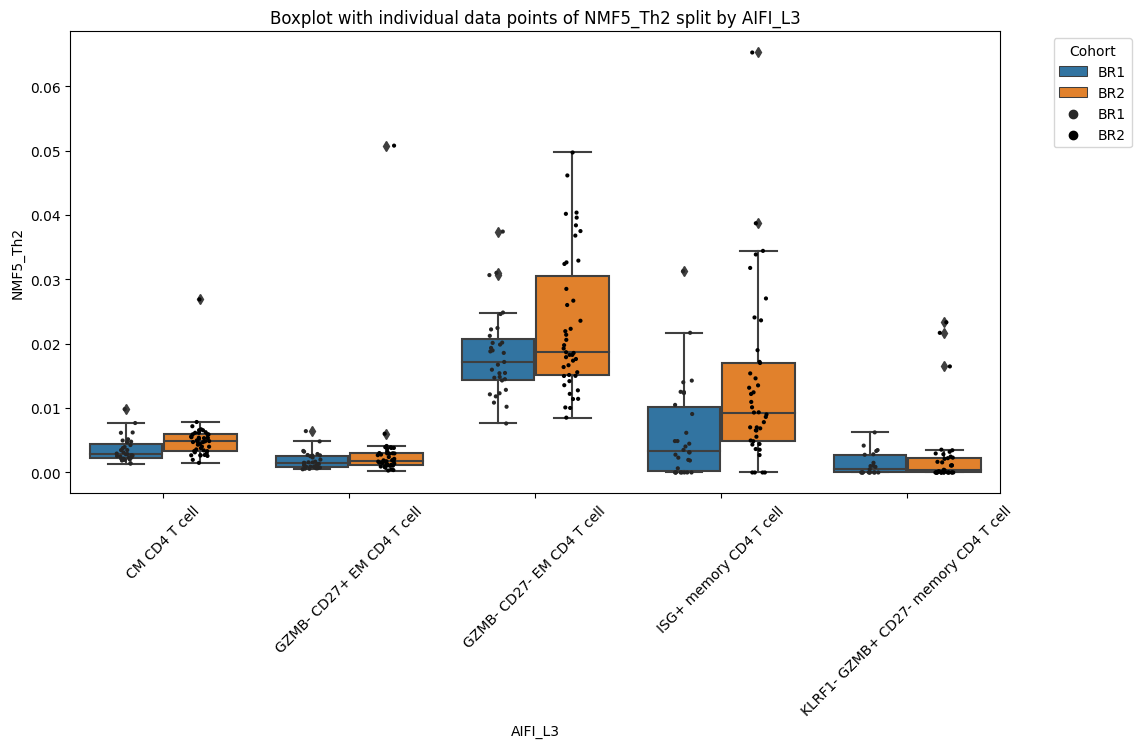

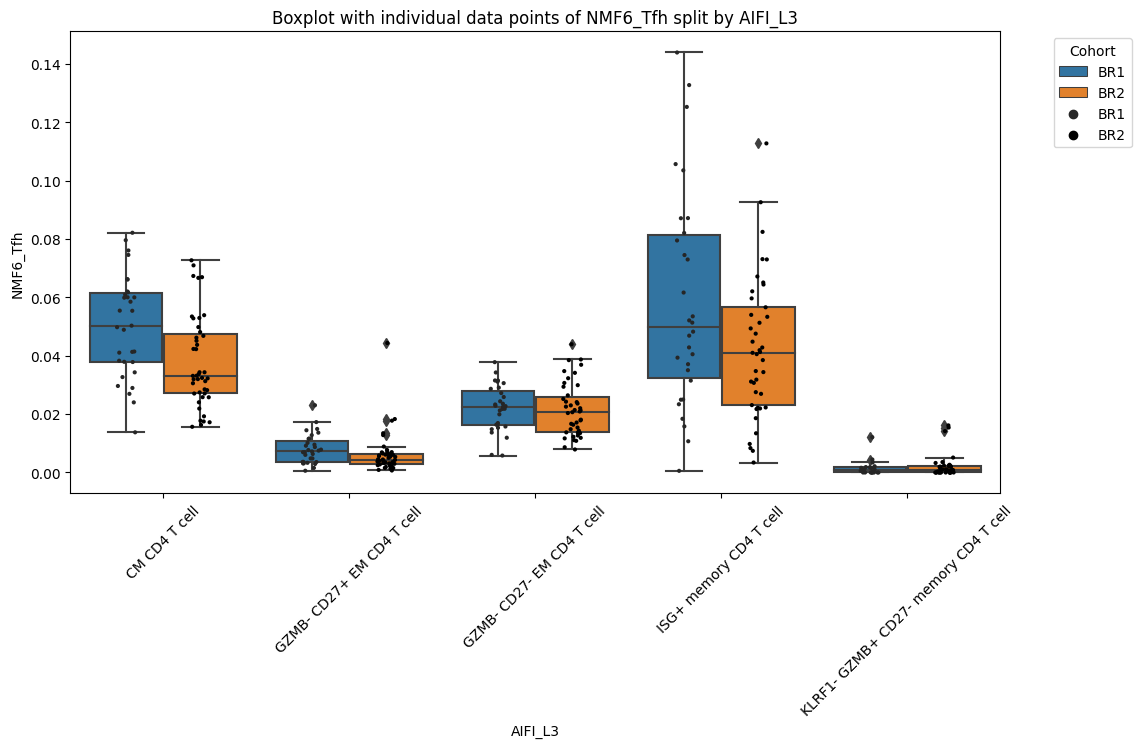

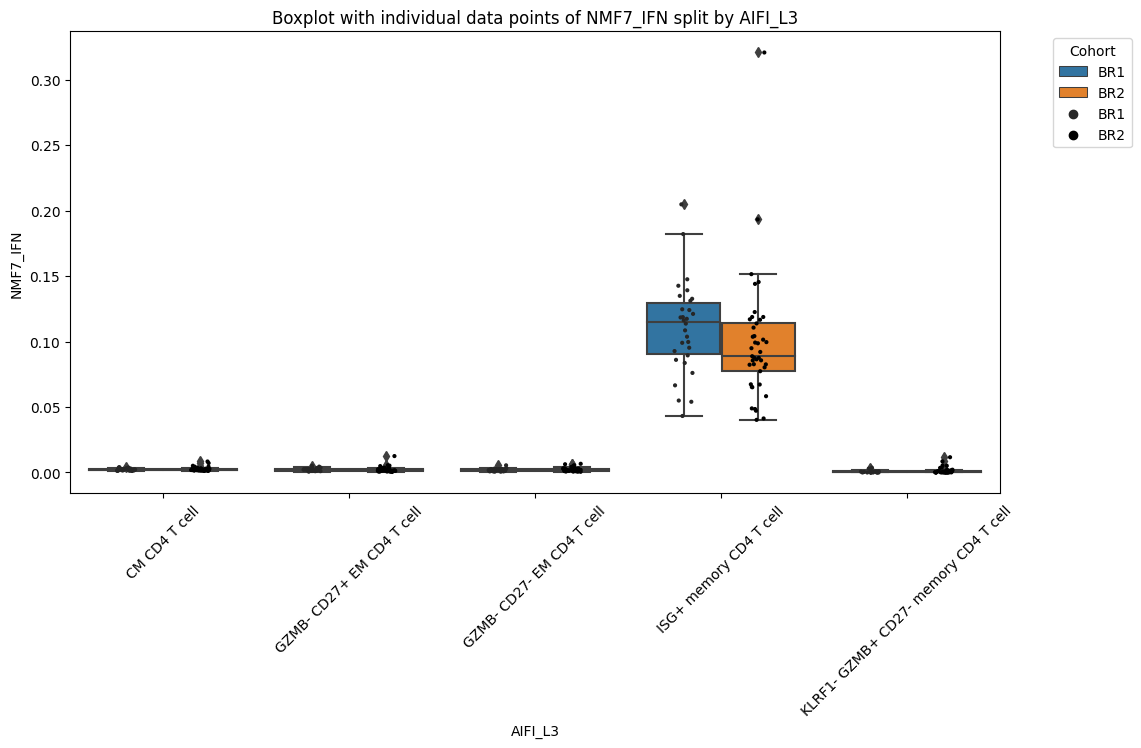

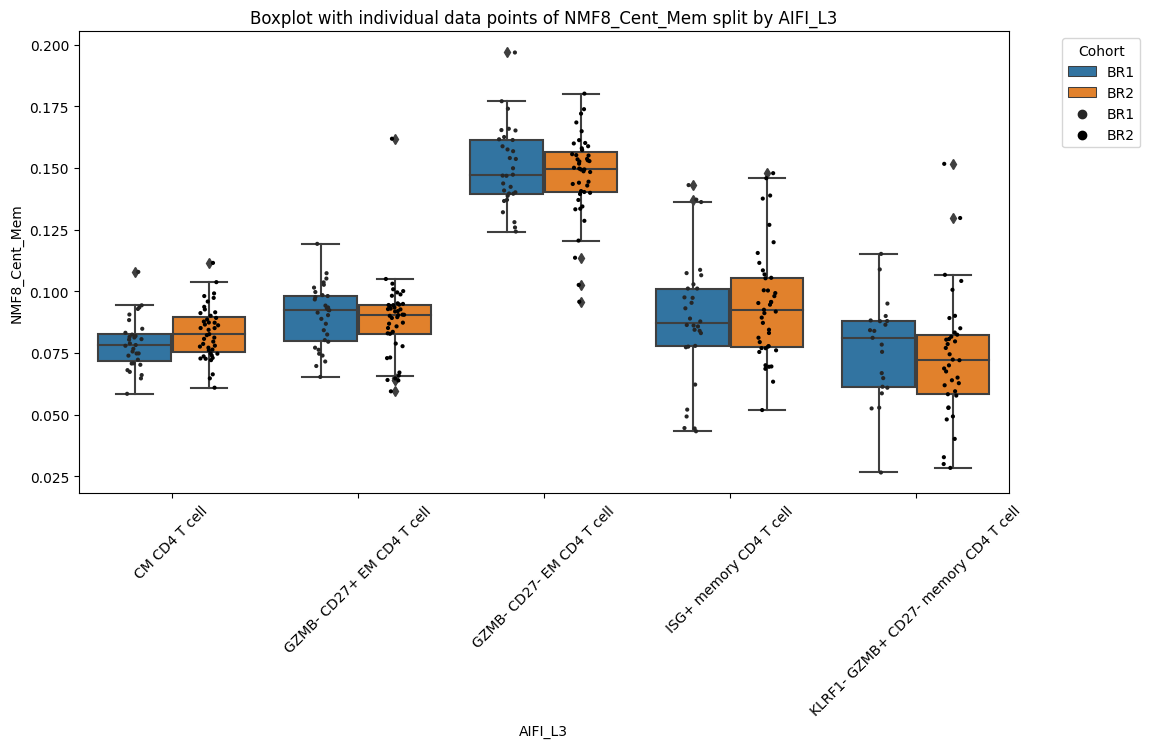

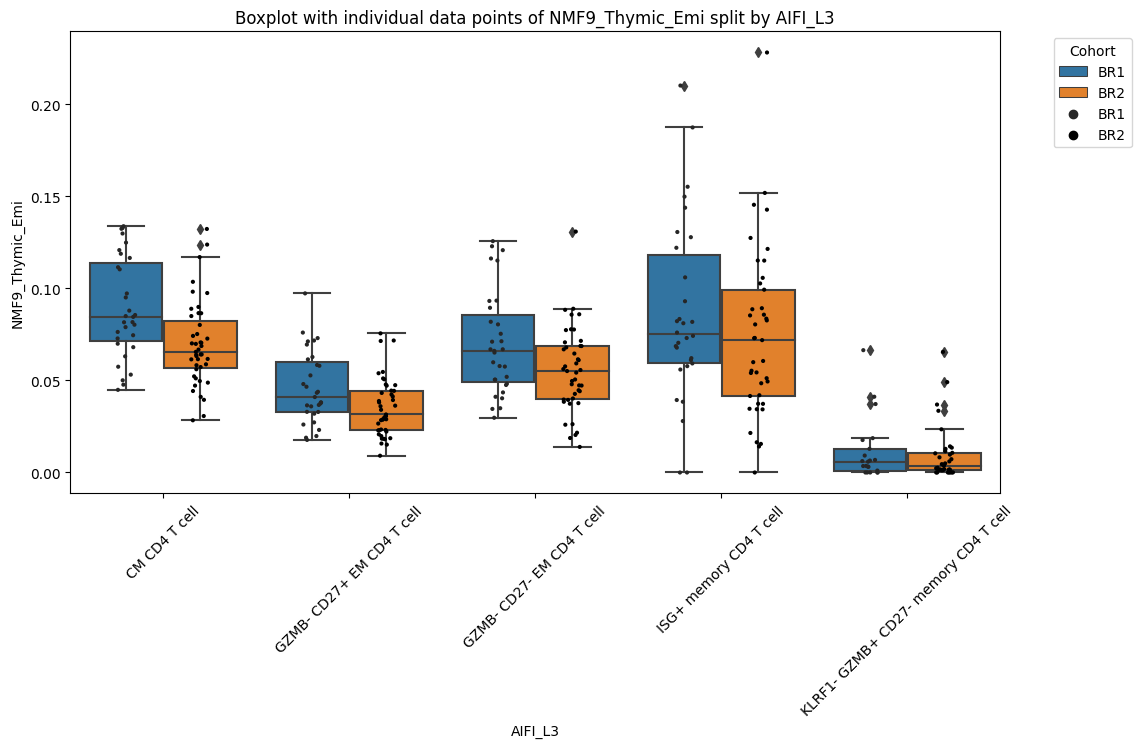

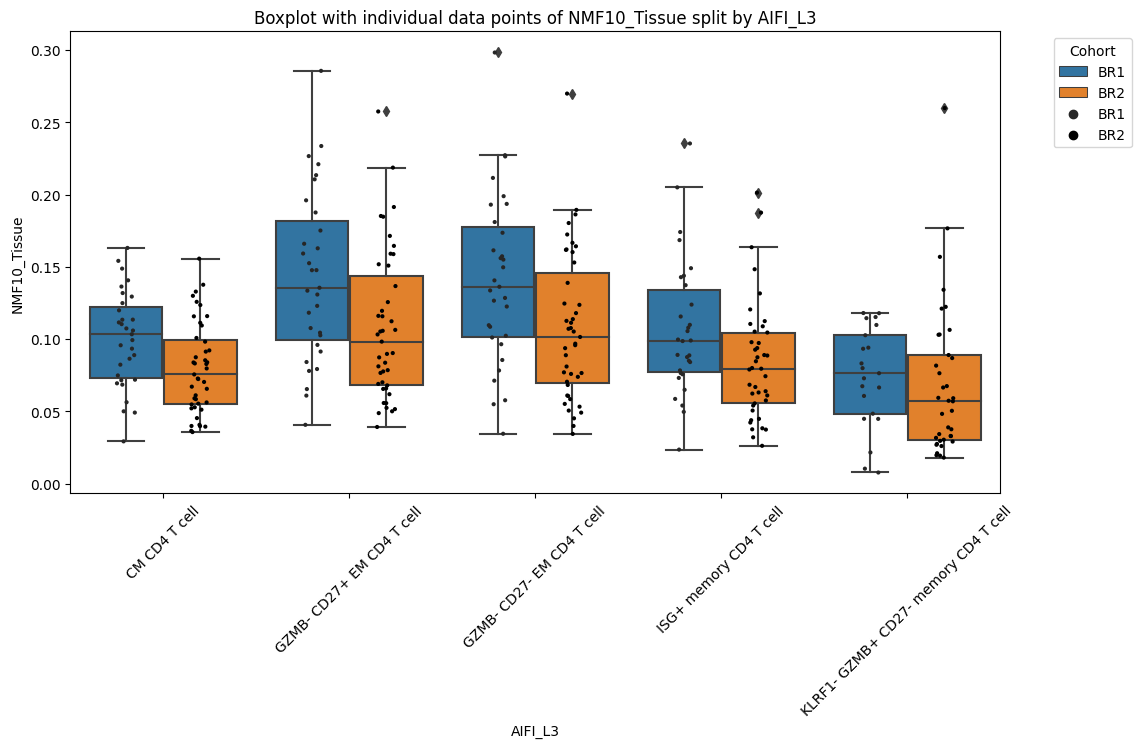

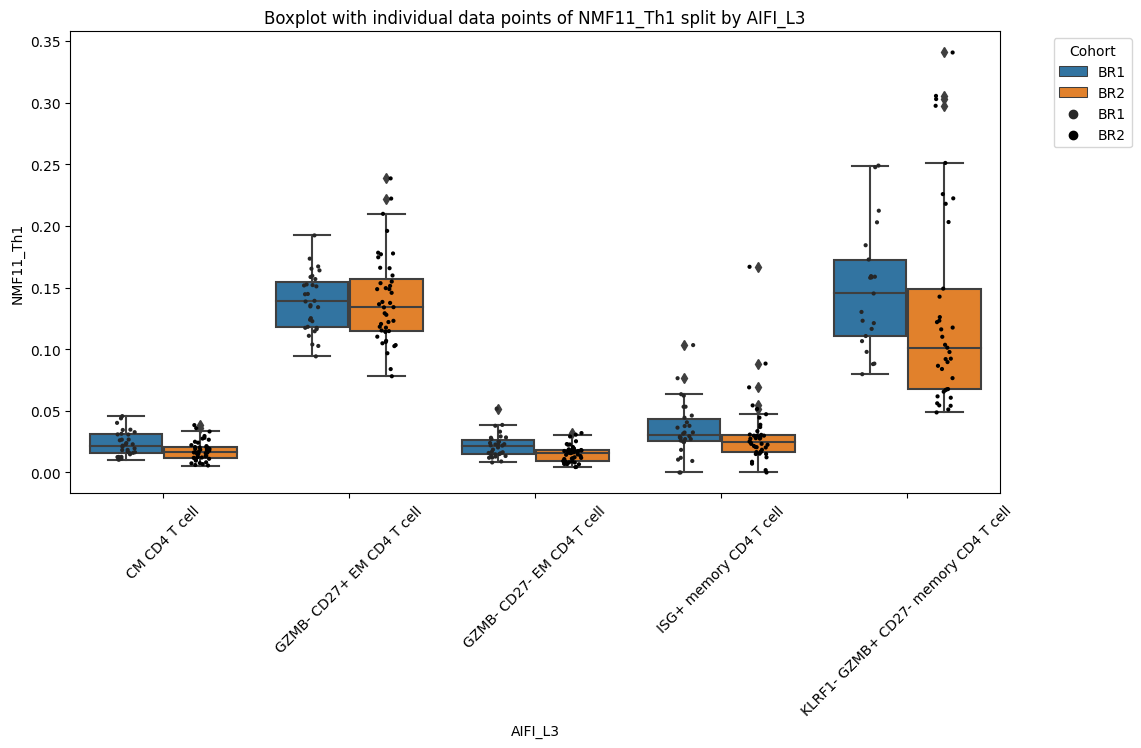

In [76]:
# Assuming 'grouped_reset' is your DataFrame
for nmf_col in nmf_cols:
    plt.figure(figsize=(12, 6))

    # Plot boxplot with AIFI_L3 on the x-axis and cohort.cohortGuid as the hue
    sns.boxplot(x='AIFI_L3', y=nmf_col, hue='cohort.cohortGuid', data=grouped_reset)

    # Add stripplot to show all data points
    sns.stripplot(x='AIFI_L3', y=nmf_col, hue='cohort.cohortGuid', data=grouped_reset, color='black', size=3, jitter=True, dodge=True)

    plt.title(f'Boxplot with individual data points of {nmf_col} split by AIFI_L3')

    # Move legend to the right
    plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Variables for staggered lines and annotations
    p_values = []
    fold_changes = []
    cohorts = grouped_reset['cohort.cohortGuid'].unique()
    aifi_categories = grouped_reset['AIFI_L3'].unique()
    offset_factor = 0.1
    max_y = grouped_reset[nmf_col].max()
    for i, aifi_category in enumerate(aifi_categories):
        for cohort in cohorts:
            # Filter for each AIFI_L3 category and cohort
            subset = grouped_reset[(grouped_reset['AIFI_L3'] == aifi_category) & (grouped_reset['cohort.cohortGuid'] == cohort)]

            # Calculate mean for fold change
            mean_val = subset[nmf_col].mean() if not subset.empty else np.nan
            fold_changes.append(mean_val)

        # Perform t-test between BR1 and BR2 for each AIFI_L3 category
        br1 = grouped_reset[(grouped_reset['AIFI_L3'] == aifi_category) & (grouped_reset['cohort.cohortGuid'] == 'BR1')][nmf_col]
        br2 = grouped_reset[(grouped_reset['AIFI_L3'] == aifi_category) & (grouped_reset['cohort.cohortGuid'] == 'BR2')][nmf_col]
        t_stat, p_val = ttest_ind(br1, br2, nan_policy='omit')
        p_values.append(p_val)

    # Adjust p-values for multiple comparisons
    _, p_adj, _, _ = multipletests(p_values, method='fdr_bh')

    plt.xticks(rotation=45)
    plt.show()

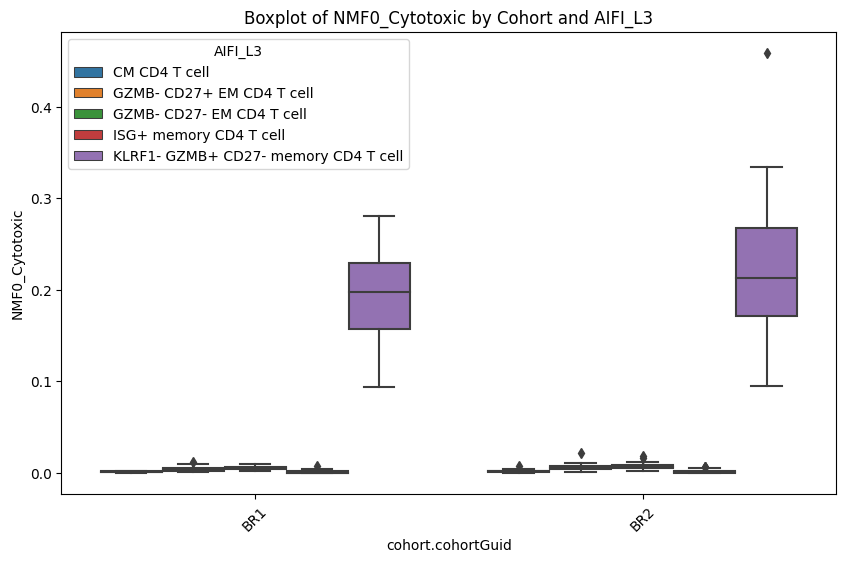

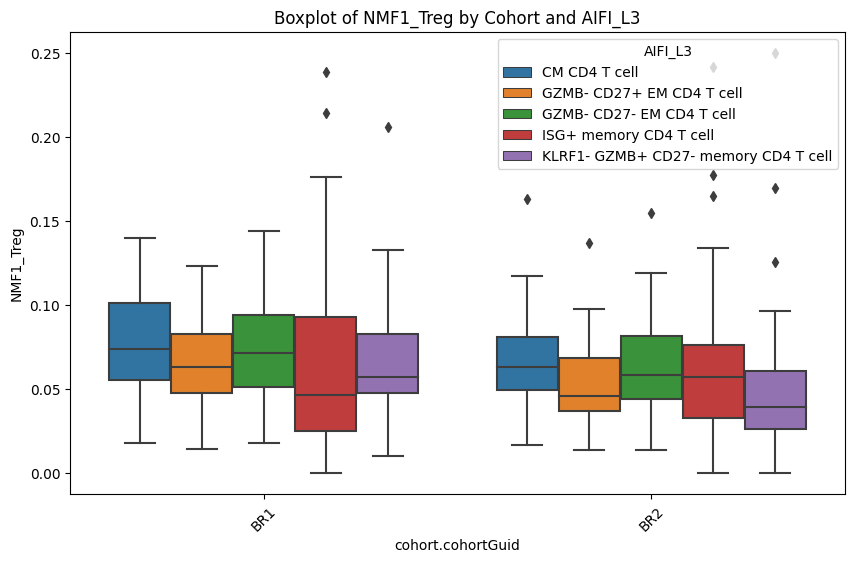

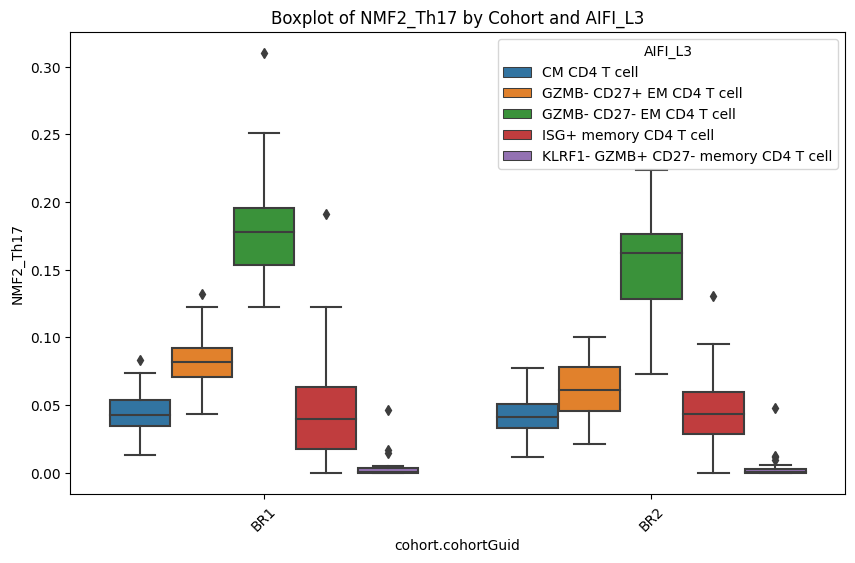

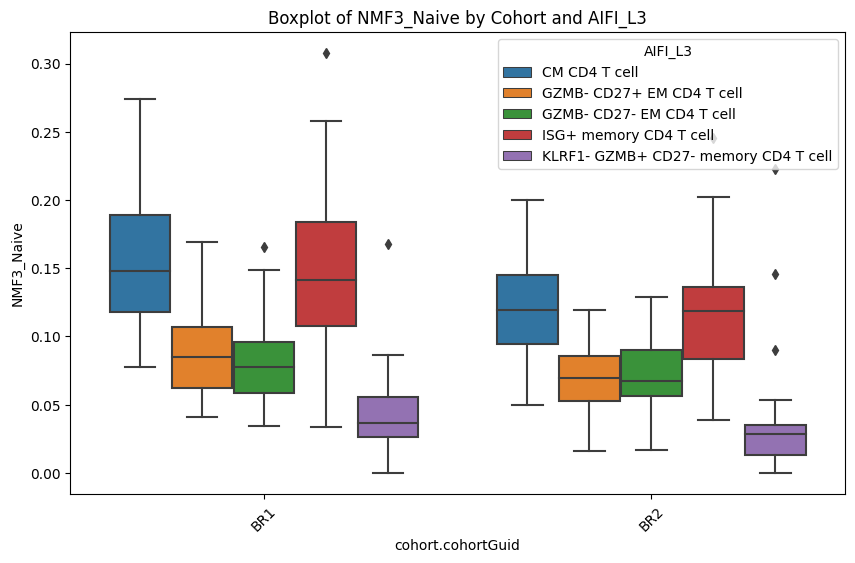

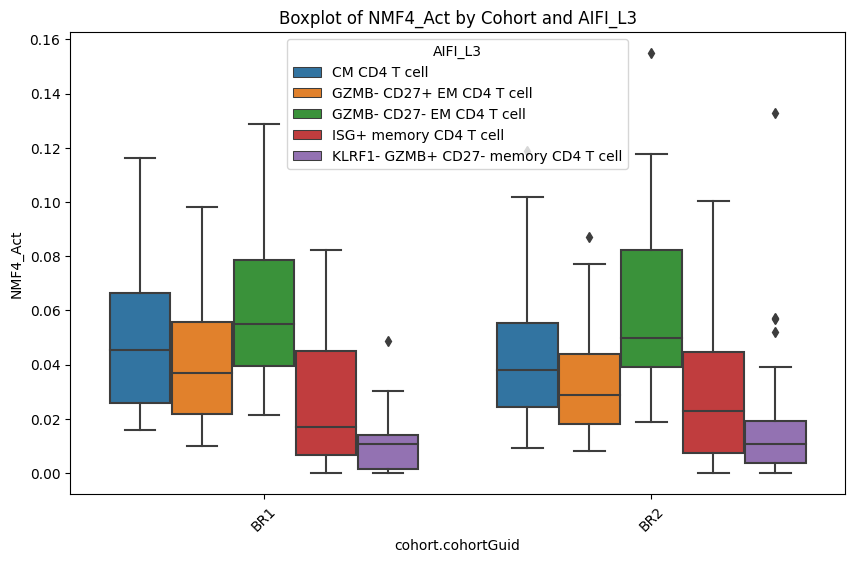

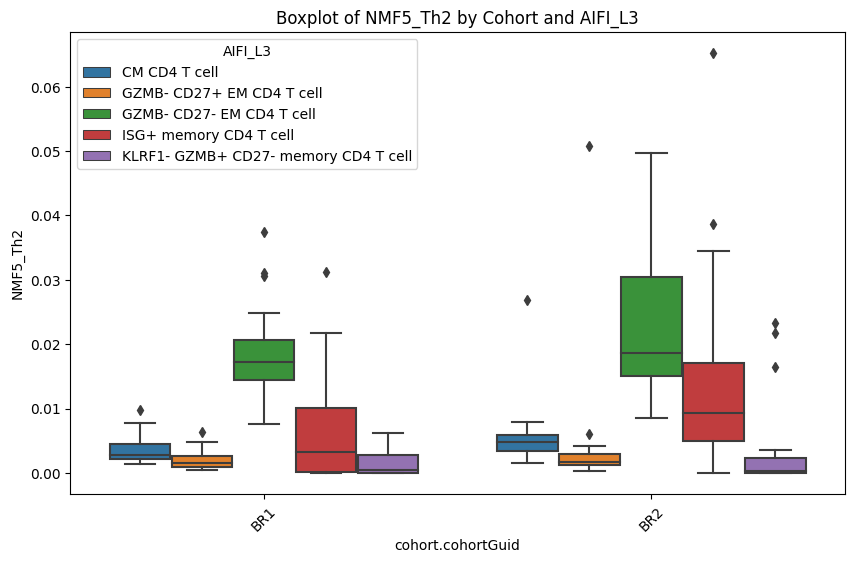

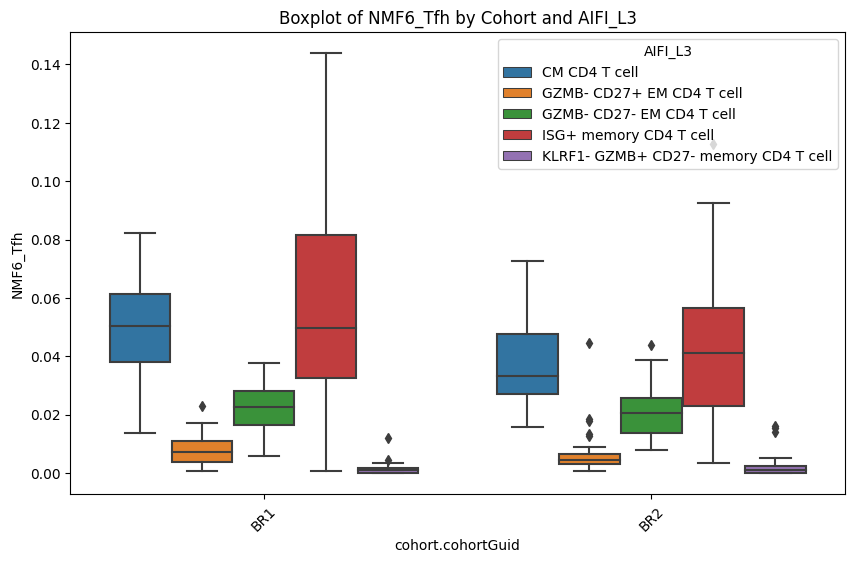

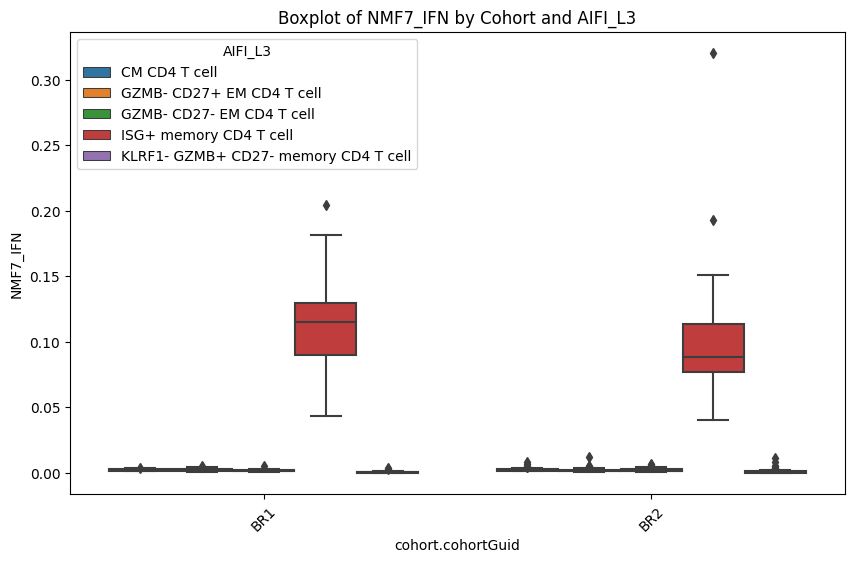

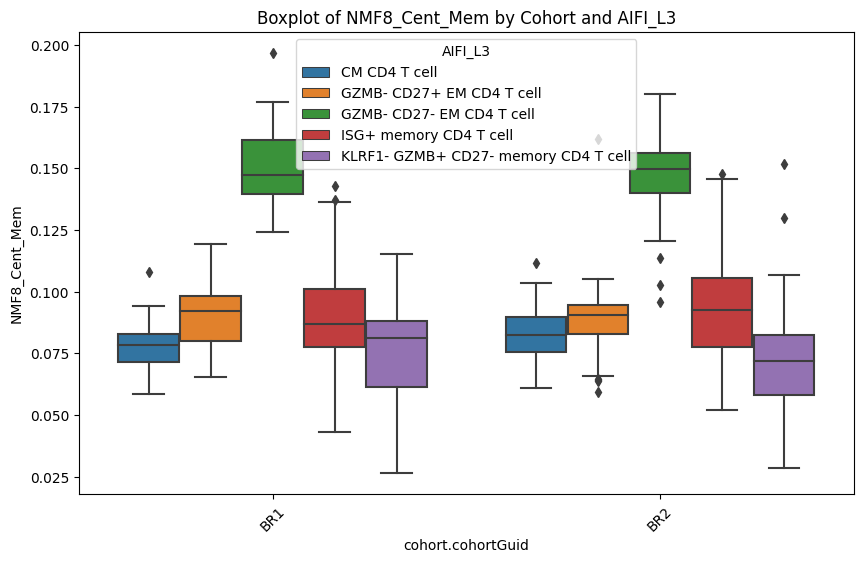

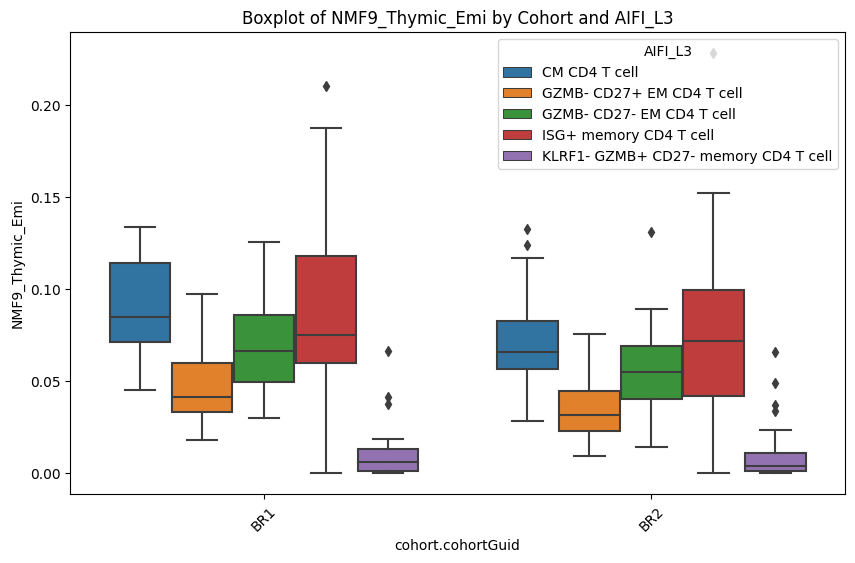

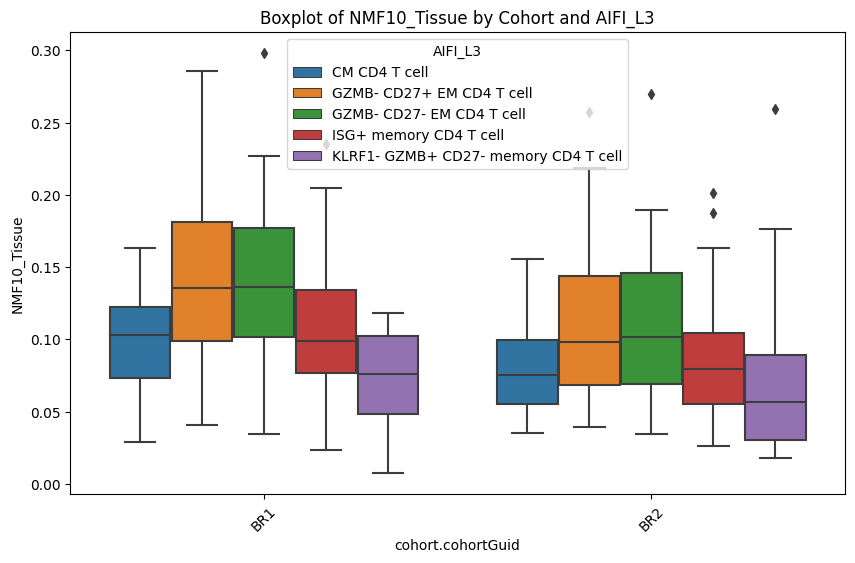

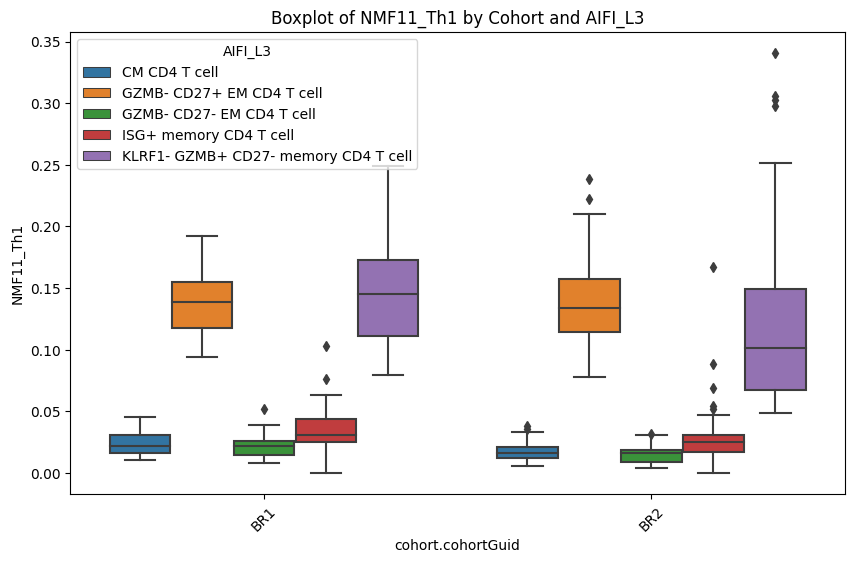

In [27]:
List of your .h5ad file paths
h5ad_files = [
    '/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr1d0.h5ad',
    '/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr1d7.h5ad',
    '/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr2d0.h5ad',
    '/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_mem_yr2d7.h5ad'
]

# NMF features
# nmf_features = [
#     'NMF0_Cytotoxic', 'NMF1_Treg', 'NMF2_Th17', 'NMF3_Naive', 'NMF4_Act',
#     'NMF5_Th2', 'NMF6_Tfh', 'NMF7_IFN', 'NMF8_Cent_Mem', 'NMF9_Thymic_Emi',
#     'NMF10_Tissue', 'NMF11_Th1'
# ]

for file in h5ad_files:
    # Load AnnData object
    adata = sc.read_h5ad(file)
    df = adata.obs.copy()

    # Filter columns for NMF and necessary categorical data
    nmf_cols = [col for col in df.columns if col.startswith('NMF')]
    cat_cols = ['subject.subjectGuid', 'AIFI_L3']
    df_filtered = df[nmf_cols + cat_cols]

    # Group by 'subject.subjectGuid' and 'AIFI_L3', then calculate the mean of NMF columns
    # For 'cohort.cohortGuid', take the first value
    grouped = df_filtered.groupby(['subject.subjectGuid', 'AIFI_L3']).mean()
    grouped['cohort.cohortGuid'] = df.groupby(['subject.subjectGuid', 'AIFI_L3'])['cohort.cohortGuid'].first()

    # Reset the index for plotting
    grouped_reset = grouped.reset_index()

    # Save to CSV
    output_filename = f"grouped_means_{os.path.basename(file).split('.')[0]}.csv"
    grouped_reset.to_csv(f'/path/to/save/directory/{output_filename}', index=False)

    print(f"Saved grouped means for {file} as {output_filename}")

    # Boxplot for each NMF feature
    for nmf_col in nmf_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cohort.cohortGuid', y=nmf_col, hue='AIFI_L3', data=grouped_reset)
    plt.title(f'Boxplot of {nmf_col} by Cohort and AIFI_L3')
    plt.xticks(rotation=45)
    plt.show()

ValueError: Shape of passed values is (10000, 1), indices imply (10000, 33538)

## Subset on all CD4s

In [5]:
#subset on all CD4
subset_pops = ['Core naive CD4 T cell',
 'CM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'CD4 MAIT',
 'KLRB1+ memory CD4 Treg',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'Naive CD4 Treg',
 'GZMB- CD27- EM CD4 T cell',
 'ISG+ naive CD4 T cell',
 'Memory CD4 Treg',
 'ISG+ memory CD4 T cell',
 'GZMK+ memory CD4 Treg',
 'SOX4+ naive CD4 T cell',
'Proliferating T cell']

CD4mem = load_data[load_data.obs['AIFI_L3'].isin(subset_pops)]
#CD4mem = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 1 Day 0', 'Flu Year 1 Day 7', 'Flu Year 2 Day 0', 'Flu Year 2 Day 7'])]
CD4_all_yr1d0 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 1 Day 0'])]
CD4_all_yr1d7 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 1 Day 7'])]
CD4_all_yr2d0 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 2 Day 0'])]
CD4_all_yr2d7 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 2 Day 7'])]
#CD4mem = load_data[load_data.obs['AIFI_L3'].isin(['CM CD4 T cell', 'GZMB- CD27+ EM CD4 T cell', 'GZMB- CD27- EM CD4 T cell', 'KLRF1- GZMB+ CD27- memory CD4 T cell', 'ISG+ memory CD4 T cell'])]
# CD4mem_yr1 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 1 Day 0'])]
# CD4mem_yr2 = CD4mem[CD4mem.obs['sample.visitName'].isin(['Flu Year 2 Day 0'])]

In [6]:
CD4_all_yr1d0.raw = CD4_all_yr1d0

In [7]:
CD4_all_yr1d0.raw.X

<621032x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 941020244 stored elements in Compressed Sparse Row format>

2024-03-26 07:41:54,678 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-26 07:45:14,552 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-26 07:45:16,960 - harmonypy - INFO - Iteration 1 of 30
2024-03-26 07:51:22,357 - harmonypy - INFO - Iteration 2 of 30
2024-03-26 07:55:55,476 - harmonypy - INFO - Iteration 3 of 30
2024-03-26 08:00:48,997 - harmonypy - INFO - Iteration 4 of 30
2024-03-26 08:04:11,284 - harmonypy - INFO - Iteration 5 of 30
2024-03-26 08:05:41,463 - harmonypy - INFO - Iteration 6 of 30
2024-03-26 08:07:06,933 - harmonypy - INFO - Converged after 6 iterations


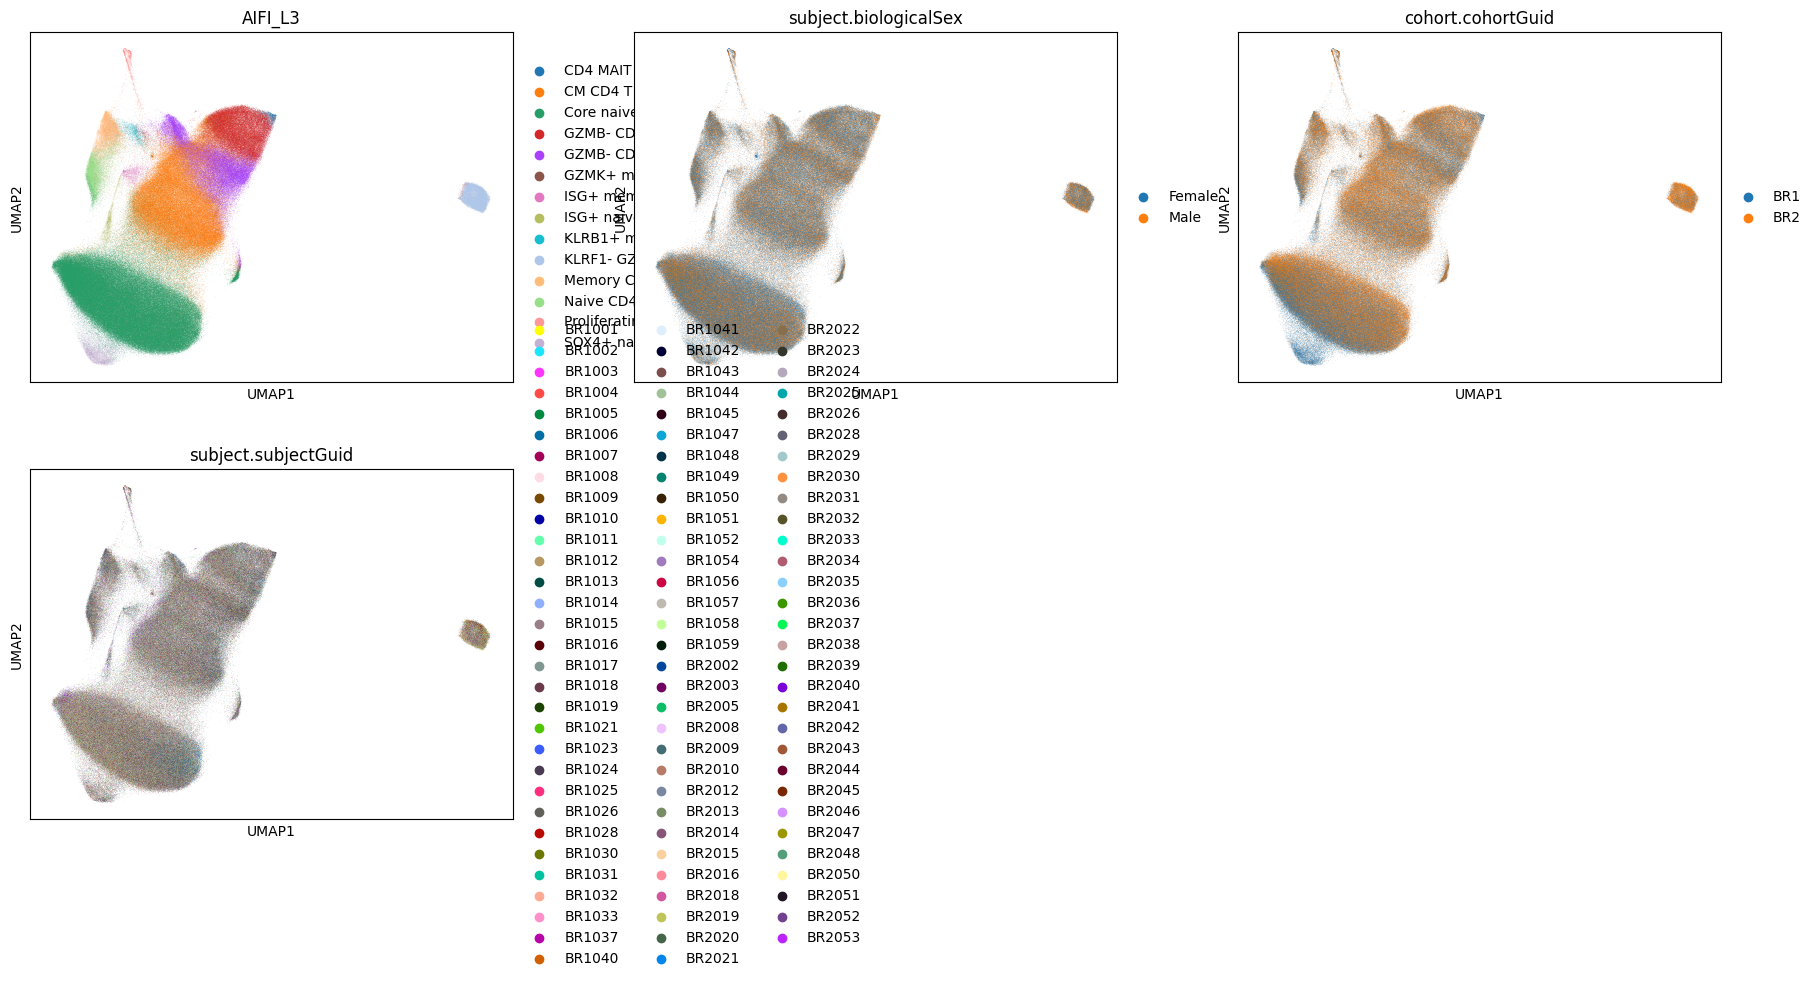

CPU times: user 8h 29min 45s, sys: 8h 34min 32s, total: 17h 4min 18s
Wall time: 54min 59s


In [8]:
%%time
sc.pp.normalize_total(CD4_all_yr1d0, target_sum=1e4, inplace=True)
sc.pp.log1p(CD4_all_yr1d0)
sc.pp.highly_variable_genes(CD4_all_yr1d0, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(CD4_all_yr1d0)
sc.tl.pca(CD4_all_yr1d0, svd_solver='arpack')
sce.pp.harmony_integrate(CD4_all_yr1d0, 'subject.biologicalSex', max_iter_harmony = 30)
sc.pp.neighbors(CD4_all_yr1d0, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(CD4_all_yr1d0, min_dist=0.05)
sc.pl.umap(CD4_all_yr1d0,color=['AIFI_L3', 'subject.biologicalSex','cohort.cohortGuid','subject.subjectGuid'],ncols=3)

In [9]:
CD4_all_yr1d0.write('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_all_yr1d0.h5ad')

2024-03-26 08:51:46,241 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-26 08:55:47,591 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-26 08:55:50,107 - harmonypy - INFO - Iteration 1 of 30
2024-03-26 09:00:22,419 - harmonypy - INFO - Iteration 2 of 30
2024-03-26 09:04:41,883 - harmonypy - INFO - Iteration 3 of 30
2024-03-26 09:09:16,709 - harmonypy - INFO - Iteration 4 of 30
2024-03-26 09:10:37,139 - harmonypy - INFO - Iteration 5 of 30
2024-03-26 09:12:04,293 - harmonypy - INFO - Iteration 6 of 30
2024-03-26 09:13:29,183 - harmonypy - INFO - Iteration 7 of 30
2024-03-26 09:17:18,850 - harmonypy - INFO - Iteration 8 of 30
2024-03-26 09:18:39,174 - harmonypy - INFO - Iteration 9 of 30
2024-03-26 09:20:05,800 - harmonypy - INFO - Iteration 10 of 30
2024-03-26 09:21:33,348 - harmonypy - INFO - Iteration 11 of 30
2024-03-26 09:23:00,667 - harmonypy - INFO - Converged after 11 iterations


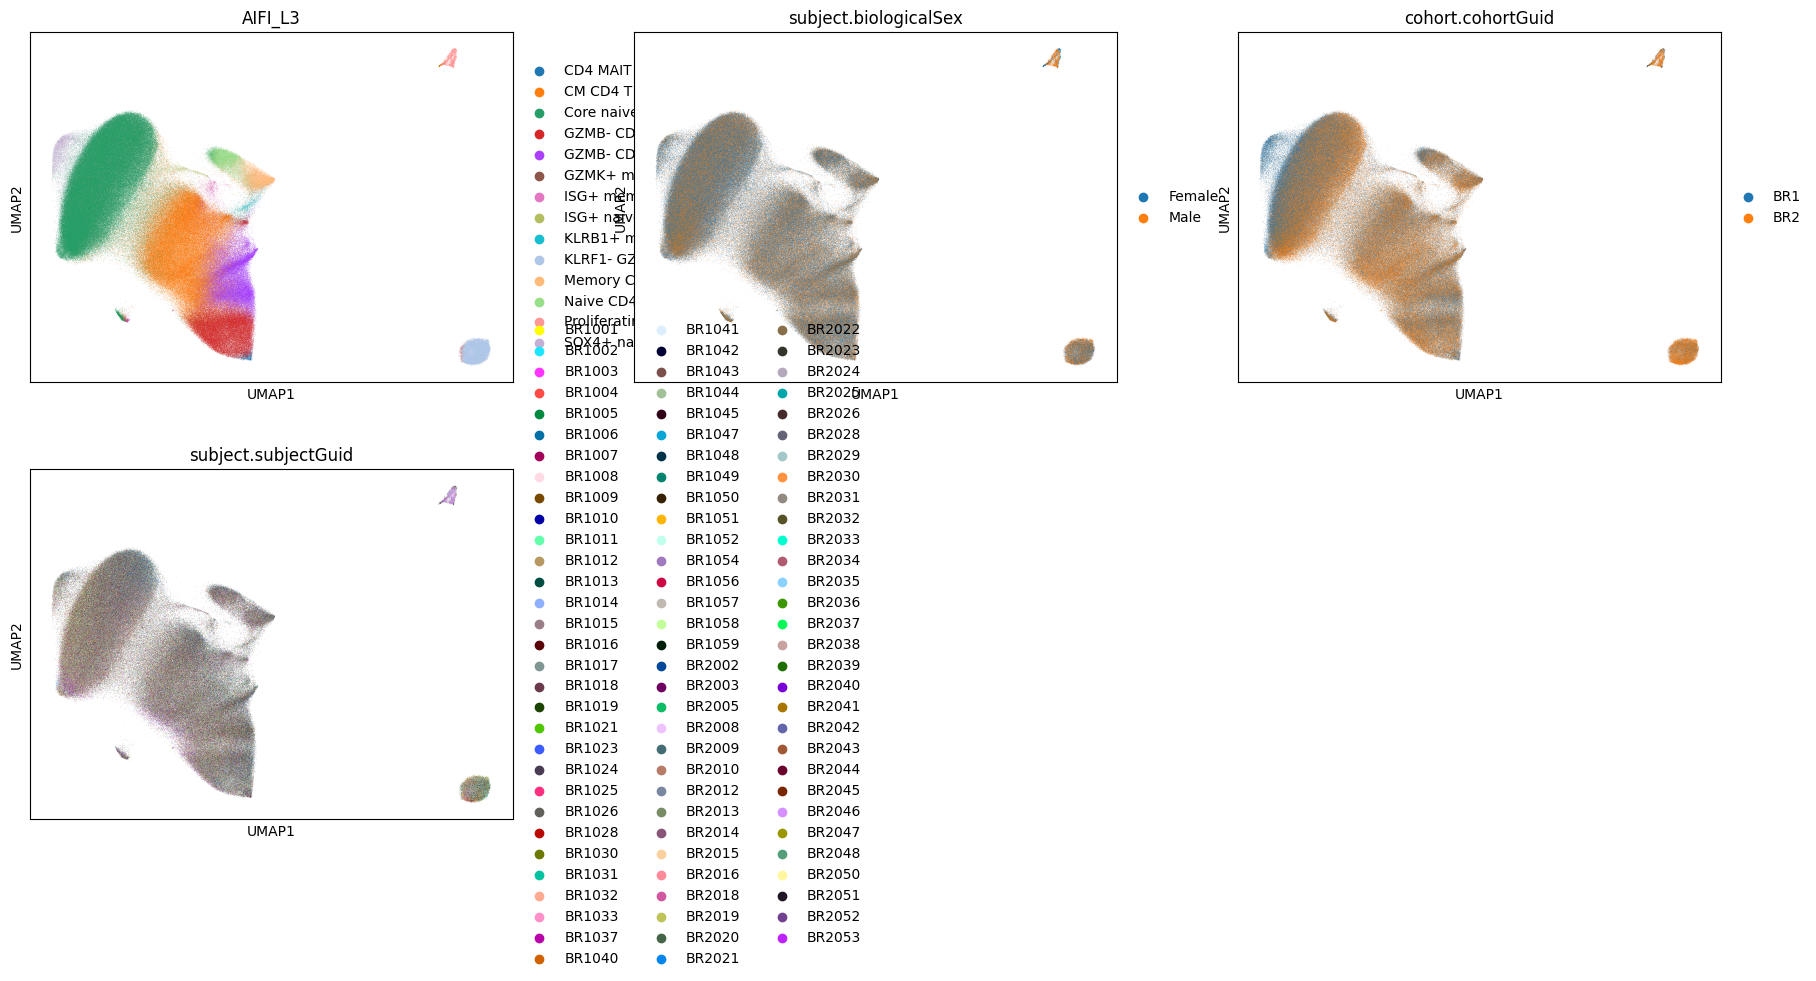

In [10]:
CD4_all_yr1d7.raw = CD4_all_yr1d7
CD4_all_yr1d7.raw.X
sc.pp.normalize_total(CD4_all_yr1d7, target_sum=1e4, inplace=True)
sc.pp.log1p(CD4_all_yr1d7)
sc.pp.highly_variable_genes(CD4_all_yr1d7, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(CD4_all_yr1d7)
sc.tl.pca(CD4_all_yr1d7, svd_solver='arpack')
sce.pp.harmony_integrate(CD4_all_yr1d7, 'subject.biologicalSex',max_iter_harmony = 30)
sc.pp.neighbors(CD4_all_yr1d7, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(CD4_all_yr1d7, min_dist=0.05)
sc.pl.umap(CD4_all_yr1d7,color=['AIFI_L3', 'subject.biologicalSex','cohort.cohortGuid','subject.subjectGuid'],ncols=3)

In [11]:
CD4_all_yr1d7.write('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_all_yr1d7.h5ad')

2024-03-26 09:54:26,602 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-26 09:58:15,768 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-26 09:58:18,553 - harmonypy - INFO - Iteration 1 of 30
2024-03-26 10:04:03,894 - harmonypy - INFO - Iteration 2 of 30
2024-03-26 10:09:26,732 - harmonypy - INFO - Iteration 3 of 30
2024-03-26 10:14:25,184 - harmonypy - INFO - Iteration 4 of 30
2024-03-26 10:16:16,994 - harmonypy - INFO - Converged after 4 iterations


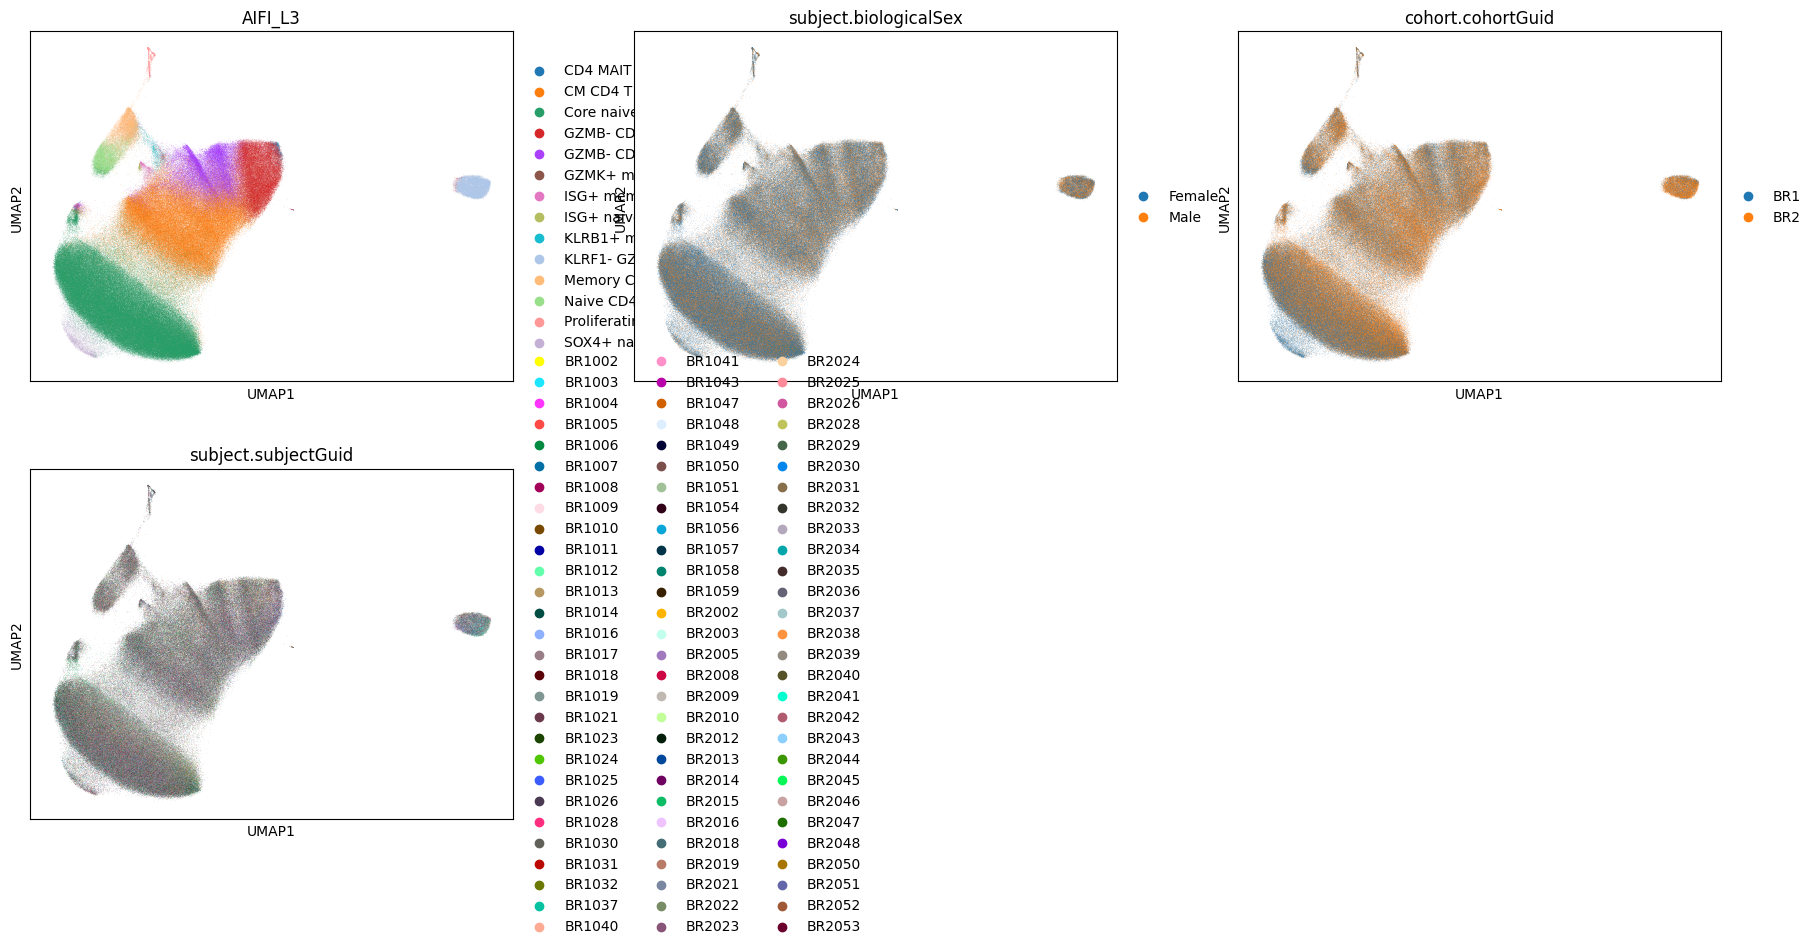

In [12]:
CD4_all_yr2d0.raw = CD4_all_yr2d0
CD4_all_yr2d0.raw.X
sc.pp.normalize_total(CD4_all_yr2d0, target_sum=1e4, inplace=True)
sc.pp.log1p(CD4_all_yr2d0)
sc.pp.highly_variable_genes(CD4_all_yr2d0, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(CD4_all_yr2d0)
sc.tl.pca(CD4_all_yr2d0, svd_solver='arpack')
sce.pp.harmony_integrate(CD4_all_yr2d0, 'subject.biologicalSex',max_iter_harmony = 30)
sc.pp.neighbors(CD4_all_yr2d0, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(CD4_all_yr2d0, min_dist=0.05)
sc.pl.umap(CD4_all_yr2d0,color=['AIFI_L3', 'subject.biologicalSex','cohort.cohortGuid','subject.subjectGuid'],ncols=3)

In [13]:
CD4_all_yr2d0.write('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_all_yr2d0.h5ad')

In [ ]:
CD4_all_yr2d7.raw = CD4_all_yr2d7
CD4_all_yr2d7.raw.X
sc.pp.normalize_total(CD4_all_yr2d7, target_sum=1e4, inplace=True)
sc.pp.log1p(CD4_all_yr2d7)
sc.pp.highly_variable_genes(CD4_all_yr2d7, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(CD4_all_yr2d7)
sc.tl.pca(CD4_all_yr2d7, svd_solver='arpack')
sce.pp.harmony_integrate(CD4_all_yr2d7, 'subject.biologicalSex',max_iter_harmony = 30)
sc.pp.neighbors(CD4_all_yr2d7, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(CD4_all_yr2d7, min_dist=0.05)
sc.pl.umap(CD4_all_yr2d7,color=['AIFI_L3', 'subject.biologicalSex','cohort.cohortGuid','subject.subjectGuid'],ncols=3)

In [ ]:
CD4_all_yr2d7.write('/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_all_yr2d7.h5ad')

# Load Year 1 Day 0 data

In [ ]:
%%time
CD4_all_yr1d0=sc.read_h5ad("/home/jupyter/formal_BRIanalysis/CD4 mem analysis/CD4_all_yr1d0.h5ad")

In [ ]:
CD4_all_yr1d0

In [ ]:
#subset on the memory CD4 compartment, and then subset on year 1 day 0 and year 2 day 0 separately
subset_pops = ['CM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'KLRB1+ memory CD4 Treg',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'Naive CD4 Treg',
 'GZMB- CD27- EM CD4 T cell',
 'Memory CD4 Treg',
 'ISG+ memory CD4 T cell',
 'GZMK+ memory CD4 Treg',
'Proliferating T cell']

CD4_all_yr1d0_s = CD4_all_yr1d0[CD4_all_yr1d0.obs['AIFI_L3'].isin(subset_pops)]

In [ ]:
#randomly take 10,000 cells
random_subset = np.random.choice(CD4_all_yr1d0_s.obs.index, size=10000, replace=False)
subsampled_adata = CD4_all_yr1d0_s[random_subset, :]

In [ ]:
fixed_W=pd.read_csv("/home/jupyter/formal_BRIanalysis/CD4 mem analysis/NMF.W.CD4T (1).csv")

In [ ]:
fixed_W = fixed_W.rename(columns={'Unnamed: 0': ''})
fixed_W.set_index(fixed_W.columns[0], inplace=True)

In [ ]:
%%time
#X = CD4_all_yr1d0.raw.to_adata().to_df().T
X = subsampled_adata.raw.to_adata().to_df().T

In [ ]:
%%time
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(X, fixed_W, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)
df_stats = calc_hvg_overlap(X_norm, fixed_W_trunc, min_mean=0.0125, max_mean=3, min_disp=0.1,
                            n_top_genes=500)
print('\n## Stats of overlap of HVGs')
msg = 'Num. genes in fixed W: %s \n' % fixed_W.shape[0]
msg += 'Num. Retained genes (Prop.): %s (%s)\n' % (fixed_W_trunc.shape[0], fixed_W_trunc.shape[0]/fixed_W.shape[0])
msg += 'Prop. overlap of HVGs (POH) : {} in {} query HVGs'.format(
    df_stats.loc[df_stats['highly_variable'], 'selected'].sum() / df_stats['highly_variable'].sum(), 
    df_stats.highly_variable.sum())
print(msg)

In [ ]:
index_mapping = {
    'NMF_0': 'NMF0_Cytotoxic',
    'NMF_1': 'NMF1_Treg',
    'NMF_2': 'NMF2_Th17',
    'NMF_3': 'NMF3_Naive',
    'NMF_4': 'NMF4_Act',
    'NMF_5': 'NMF5_Th2',
    'NMF_6': 'NMF6_Tfh',
    'NMF_7': 'NMF7_IFN',
    'NMF_8': 'NMF8_Cent_Mem',
    'NMF_9': 'NMF9_Thymic_Emi',
    'NMF_10': 'NMF10_Tissue',
    'NMF_11': 'NMF11_Th1'
}

# Rename the index using the mapping
df_H.index = df_H.index.map(index_mapping)

In [ ]:
#norm each cell weights
df_H_norm = (df_H.T / df_H.max(axis=1))

In [ ]:
%%time
CD4_all_yr1d0.obs = pd.merge(CD4_all_yr1d0.obs, df_H_norm, left_index=True, right_index=True)

In [ ]:
CD4_all_yr1d0

In [ ]:
sc.pl.umap(CD4_all_yr1d0, color=df_H_norm.columns,
           use_raw=True, ncols=1, vmax=1, cmap='cividis')

In [ ]:
sc.pl.umap(CD4_all_yr1d0, color='AIFI_L3',
           use_raw=True, ncols=1, vmax=1, cmap='cividis')

In [ ]:
sc.pl.umap(CD4_all_yr1d0, color='cohort.cohortGuid',
           use_raw=True, ncols=1, vmax=1, cmap='cividis')